In [1]:

!git clone https://github.com/MarsImmortal/neural_factorization_machine.git


Cloning into 'neural_factorization_machine'...
remote: Enumerating objects: 169, done.
remote: Counting objects: 100% (145/145), done.
remote: Compressing objects: 100% (98/98), done.
remote: Total 169 (delta 74), reused 117 (delta 46), pack-reused 24 (from 1)
Receiving objects: 100% (169/169), 31.58 MiB | 16.66 MiB/s, done.
Resolving deltas: 100% (79/79), done.


In [2]:
%cd neural_factorization_machine

/content/neural_factorization_machine


In [5]:
import numpy as np
import os

class LoadData(object):
    '''given the path of data, return the data format for DeepFM
    :param path
    return:
    Train_data: a dictionary, 'Y' refers to a list of y values; 'X' refers to a list of features_M dimension vectors with 0 or 1 entries
    Test_data: same as Train_data
    Validation_data: same as Train_data
    '''

    def __init__(self, path, dataset, loss_type):
        self.path = path + dataset + "/"
        self.trainfile = self.path + dataset +".train.libfm"
        self.testfile = self.path + dataset + ".test.libfm"
        self.validationfile = self.path + dataset + ".validation.libfm"
        self.features_M = self.map_features()
        self.Train_data, self.Validation_data, self.Test_data = self.construct_data(loss_type)

    def map_features(self):
        self.features = {}
        self.read_features(self.trainfile)
        self.read_features(self.testfile)
        self.read_features(self.validationfile)
        return len(self.features)

    def read_features(self, file):
        with open(file) as f:
            line = f.readline()
            i = len(self.features)
            while line:
                items = line.strip().split(' ')
                for item in items[1:]:
                    if item not in self.features:
                        self.features[item] = i
                        i += 1
                line = f.readline()

    def construct_data(self, loss_type):
        X_, Y_, Y_for_logloss = self.read_data(self.trainfile)
        Train_data = self.construct_dataset(X_, Y_for_logloss if loss_type == 'log_loss' else Y_)
        X_, Y_, Y_for_logloss = self.read_data(self.validationfile)
        Validation_data = self.construct_dataset(X_, Y_for_logloss if loss_type == 'log_loss' else Y_)
        X_, Y_, Y_for_logloss = self.read_data(self.testfile)
        Test_data = self.construct_dataset(X_, Y_for_logloss if loss_type == 'log_loss' else Y_)
        return Train_data, Validation_data, Test_data

    def read_data(self, file):
        X_ = []
        Y_ = []
        Y_for_logloss = []
        with open(file) as f:
            line = f.readline()
            while line:
                items = line.strip().split(' ')
                Y_.append(float(items[0]))
                v = 1.0 if float(items[0]) > 0 else 0.0
                Y_for_logloss.append(v)
                X_.append([self.features[item] for item in items[1:]])
                line = f.readline()
        return X_, Y_, Y_for_logloss

    def construct_dataset(self, X_, Y_):
        Data_Dic = {}
        X_lens = [len(line) for line in X_]
        indexs = np.argsort(X_lens)
        Data_Dic['Y'] = [Y_[i] for i in indexs]
        Data_Dic['X'] = [X_[i] for i in indexs]
        return Data_Dic

    def truncate_features(self):
        num_variable = len(self.Train_data['X'][0])
        for i in range(len(self.Train_data['X'])):
            num_variable = min(num_variable, len(self.Train_data['X'][i]))
        for i in range(len(self.Train_data['X'])):
            self.Train_data['X'][i] = self.Train_data['X'][i][:num_variable]
        for i in range(len(self.Validation_data['X'])):
            self.Validation_data['X'][i] = self.Validation_data['X'][i][:num_variable]
        for i in range(len(self.Test_data['X'])):
            self.Test_data['X'][i] = self.Test_data['X'][i][:num_variable]
        return num_variable


In [7]:
import tensorflow as tf
class NeuralFM(tf.keras.Model):
    def __init__(self, feature_dim, hidden_factor, layers, keep_prob, loss_type='square_loss', activation='relu'):
        super(NeuralFM, self).__init__()
        self.feature_dim = feature_dim
        self.hidden_factor = hidden_factor
        self.layers_config = layers
        self.keep_prob = keep_prob
        self.loss_type = loss_type
        self.activation = activation

        self.embedding = tf.keras.layers.Embedding(feature_dim, hidden_factor, mask_zero=False)
        self.hidden_layers = [tf.keras.layers.Dense(layer_size, activation=activation) for layer_size in layers]
        self.output_layer = tf.keras.layers.Dense(1, activation='sigmoid' if loss_type == 'log_loss' else 'linear')
        self.dropout_layers = [tf.keras.layers.Dropout(p) for p in keep_prob]

    def call(self, inputs, training=False):
        x = self.embedding(inputs)
        fm_part = tf.reduce_sum(x, axis=1) ** 2 - tf.reduce_sum(x ** 2, axis=1)
        fm_part = 0.5 * tf.reduce_sum(fm_part, axis=1, keepdims=True)

        x = tf.reduce_sum(x, axis=1)
        for layer, dropout in zip(self.hidden_layers, self.dropout_layers):
            x = layer(x)
            if training:
                x = dropout(x)

        x = tf.concat([x, fm_part], axis=1)
        output = self.output_layer(x)
        return output

    def get_config(self):
        return {
            'feature_dim': self.feature_dim,
            'hidden_factor': self.hidden_factor,
            'layers': self.layers_config,
            'keep_prob': self.keep_prob,
            'loss_type': self.loss_type,
            'activation': self.activation,
        }

    @classmethod
    def from_config(cls, config):
        return cls(**config)


In [83]:
import tensorflow as tf
from tensorflow.keras.optimizers import Adagrad
from tensorflow.keras.callbacks import EarlyStopping, TensorBoard
from sklearn.metrics import mean_squared_error, log_loss
import numpy as np
import matplotlib.pyplot as plt
from tensorflow.keras import mixed_precision

# Enable mixed precision
policy = mixed_precision.Policy('mixed_float16')
mixed_precision.set_global_policy(policy)

# Verify GPU availability
print("Num GPUs Available: ", len(tf.config.list_physical_devices('GPU')))

# Allow memory growth
gpus = tf.config.list_physical_devices('GPU')
if gpus:
    try:
        for gpu in gpus:
            tf.config.experimental.set_memory_growth(gpu, True)
    except RuntimeError as e:
        print(e)

# Load data
path = 'data/'
dataset = 'frappe'
loss_type = 'square_loss'  # or 'log_loss'

# Initialize data loader
loader = LoadData(path, dataset, loss_type)
feature_dim = loader.features_M
hidden_factor = 64
layers = [64]
keep_prob = [0.8, 0.5]

# Create model
model = NeuralFM(
    feature_dim=feature_dim,
    hidden_factor=hidden_factor,
    layers=layers,
    keep_prob=keep_prob,
    loss_type=loss_type,
    activation='relu'
)

# Compile model
optimizer = Adagrad(learning_rate=0.05)
model.compile(
    optimizer=optimizer,
    loss='binary_crossentropy' if loss_type == 'log_loss' else 'mean_squared_error'
)

# Prepare data
def prepare_data(data):
    X = tf.keras.preprocessing.sequence.pad_sequences(data['X'], padding='post')
    y = np.array(data['Y'])
    return X, y

def create_dataset(X, y, batch_size=128, shuffle=True):
    dataset = tf.data.Dataset.from_tensor_slices((X, y))
    if shuffle:
        dataset = dataset.shuffle(buffer_size=10000)  # Adjust buffer size if necessary
    dataset = dataset.batch(batch_size).prefetch(buffer_size=tf.data.AUTOTUNE)
    return dataset

# Prepare data
X_train, y_train = prepare_data(loader.Train_data)
X_val, y_val = prepare_data(loader.Validation_data)
X_test, y_test = prepare_data(loader.Test_data)

# Create datasets with batch size
batch_size = 128
train_dataset = create_dataset(X_train, y_train, batch_size=batch_size)
val_dataset = create_dataset(X_val, y_val, batch_size=batch_size, shuffle=False)
test_dataset = create_dataset(X_test, y_test, batch_size=batch_size, shuffle=False)

# Define early stopping and TensorBoard callback
early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)
tensorboard_callback = TensorBoard(log_dir="./logs", profile_batch=0)

# Train model with callbacks
history = model.fit(
    train_dataset,
    epochs=200,
    validation_data=val_dataset,
    callbacks=[early_stopping, tensorboard_callback],
    verbose=1
)

# Save the trained model in Keras format
model.save('neural_fm_model.keras')
print("Model saved to neural_fm_model.keras")

# Evaluate model
y_pred = model.predict(test_dataset)
if loss_type == 'log_loss':
    score = log_loss(y_test, y_pred)
else:
    score = mean_squared_error(y_test, y_pred)

print(f"Test {loss_type} score: {score}")

# Plot training & validation loss values
plt.figure(figsize=(12, 6))
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Model Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend(loc='upper right')
plt.grid(True)
plt.show()

# Plot learning curves (if applicable)
# Example: Accuracy curves if you have accuracy metrics
if 'accuracy' in history.history:
    plt.figure(figsize=(12, 6))
    plt.plot(history.history['accuracy'], label='Train Accuracy')
    plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
    plt.title('Model Accuracy')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.legend(loc='upper left')
    plt.grid(True)
    plt.show()

# Predictions vs True Values (for a small subset)
sample_size = 100
sample_indices = np.random.choice(len(y_test), size=sample_size, replace=False)
y_test_sample = y_test[sample_indices]
y_pred_sample = y_pred[sample_indices]

plt.figure(figsize=(12, 6))
plt.scatter(y_test_sample, y_pred_sample, alpha=0.5)
plt.plot([min(y_test_sample), max(y_test_sample)], [min(y_test_sample), max(y_test_sample)], color='red', linestyle='--')
plt.title('Predictions vs True Values')
plt.xlabel('True Values')
plt.ylabel('Predictions')
plt.grid(True)
plt.show()


Num GPUs Available:  0
Epoch 1/200


/usr/local/lib/python3.10/dist-packages/keras/src/layers/layer.py:372: UserWarning: `build()` was called on layer 'neural_fm_25', however the layer does not have a `build()` method implemented and it looks like it has unbuilt state. This will cause the layer to be marked as built, despite not being actually built, which may cause failures down the line. Make sure to implement a proper `build()` method.
  warnings.warn(


1579/1579 ━━━━━━━━━━━━━━━━━━━━ 19s 10ms/step - loss: 0.6302 - val_loss: 0.3654
Epoch 2/200
1579/1579 ━━━━━━━━━━━━━━━━━━━━ 17s 10ms/step - loss: 0.3376 - val_loss: 0.3166
Epoch 3/200
1579/1579 ━━━━━━━━━━━━━━━━━━━━ 20s 10ms/step - loss: 0.3008 - val_loss: 0.2978
Epoch 4/200
1579/1579 ━━━━━━━━━━━━━━━━━━━━ 17s 11ms/step - loss: 0.2729 - val_loss: 0.2736
Epoch 5/200
1579/1579 ━━━━━━━━━━━━━━━━━━━━ 21s 11ms/step - loss: 0.2432 - val_loss: 0.2618
Epoch 6/200
1579/1579 ━━━━━━━━━━━━━━━━━━━━ 19s 10ms/step - loss: 0.2170 - val_loss: 0.2396
Epoch 7/200
1579/1579 ━━━━━━━━━━━━━━━━━━━━ 21s 11ms/step - loss: 0.1940 - val_loss: 0.2277
Epoch 8/200
1579/1579 ━━━━━━━━━━━━━━━━━━━━ 20s 10ms/step - loss: 0.1746 - val_loss: 0.2199
Epoch 9/200
1579/1579 ━━━━━━━━━━━━━━━━━━━━ 22s 11ms/step - loss: 0.1585 - val_loss: 0.2122
Epoch 10/200
1579/1579 ━━━━━━━━━━━━━━━━━━━━ 19s 10ms/step - loss: 0.1445 - val_loss: 0.2052
Epoch 11/200
1579/1579 ━━━━━━━━━━━━━━━━━━━━ 22s 11ms/step - loss: 0.1315 - val_loss: 0.2014
Epoch 12/

InvalidArgumentError: Graph execution error:

Detected at node cond/adagrad/cond/cond/GatherV2_1 defined at (most recent call last):
  File "/usr/lib/python3.10/runpy.py", line 196, in _run_module_as_main

  File "/usr/lib/python3.10/runpy.py", line 86, in _run_code

  File "/usr/local/lib/python3.10/dist-packages/colab_kernel_launcher.py", line 37, in <module>

  File "/usr/local/lib/python3.10/dist-packages/traitlets/config/application.py", line 992, in launch_instance

  File "/usr/local/lib/python3.10/dist-packages/ipykernel/kernelapp.py", line 619, in start

  File "/usr/local/lib/python3.10/dist-packages/tornado/platform/asyncio.py", line 195, in start

  File "/usr/lib/python3.10/asyncio/base_events.py", line 603, in run_forever

  File "/usr/lib/python3.10/asyncio/base_events.py", line 1909, in _run_once

  File "/usr/lib/python3.10/asyncio/events.py", line 80, in _run

  File "/usr/local/lib/python3.10/dist-packages/tornado/ioloop.py", line 685, in <lambda>

  File "/usr/local/lib/python3.10/dist-packages/tornado/ioloop.py", line 738, in _run_callback

  File "/usr/local/lib/python3.10/dist-packages/tornado/gen.py", line 825, in inner

  File "/usr/local/lib/python3.10/dist-packages/tornado/gen.py", line 786, in run

  File "/usr/local/lib/python3.10/dist-packages/ipykernel/kernelbase.py", line 361, in process_one

  File "/usr/local/lib/python3.10/dist-packages/tornado/gen.py", line 234, in wrapper

  File "/usr/local/lib/python3.10/dist-packages/ipykernel/kernelbase.py", line 261, in dispatch_shell

  File "/usr/local/lib/python3.10/dist-packages/tornado/gen.py", line 234, in wrapper

  File "/usr/local/lib/python3.10/dist-packages/ipykernel/kernelbase.py", line 539, in execute_request

  File "/usr/local/lib/python3.10/dist-packages/tornado/gen.py", line 234, in wrapper

  File "/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py", line 302, in do_execute

  File "/usr/local/lib/python3.10/dist-packages/ipykernel/zmqshell.py", line 539, in run_cell

  File "/usr/local/lib/python3.10/dist-packages/IPython/core/interactiveshell.py", line 2975, in run_cell

  File "/usr/local/lib/python3.10/dist-packages/IPython/core/interactiveshell.py", line 3030, in _run_cell

  File "/usr/local/lib/python3.10/dist-packages/IPython/core/async_helpers.py", line 78, in _pseudo_sync_runner

  File "/usr/local/lib/python3.10/dist-packages/IPython/core/interactiveshell.py", line 3257, in run_cell_async

  File "/usr/local/lib/python3.10/dist-packages/IPython/core/interactiveshell.py", line 3473, in run_ast_nodes

  File "/usr/local/lib/python3.10/dist-packages/IPython/core/interactiveshell.py", line 3553, in run_code

  File "<ipython-input-83-b3ff337314b7>", line 83, in <cell line: 83>

  File "/usr/local/lib/python3.10/dist-packages/keras/src/utils/traceback_utils.py", line 117, in error_handler

  File "/usr/local/lib/python3.10/dist-packages/keras/src/backend/tensorflow/trainer.py", line 318, in fit

  File "/usr/local/lib/python3.10/dist-packages/keras/src/backend/tensorflow/trainer.py", line 121, in one_step_on_iterator

  File "/usr/local/lib/python3.10/dist-packages/keras/src/backend/tensorflow/trainer.py", line 108, in one_step_on_data

  File "/usr/local/lib/python3.10/dist-packages/keras/src/backend/tensorflow/trainer.py", line 73, in train_step

  File "/usr/local/lib/python3.10/dist-packages/keras/src/optimizers/base_optimizer.py", line 282, in apply_gradients

  File "/usr/local/lib/python3.10/dist-packages/keras/src/optimizers/loss_scale_optimizer.py", line 165, in apply

  File "/usr/local/lib/python3.10/dist-packages/keras/src/optimizers/loss_scale_optimizer.py", line 216, in _tf_apply

  File "/usr/local/lib/python3.10/dist-packages/keras/src/optimizers/loss_scale_optimizer.py", line 200, in _common_apply

  File "/usr/local/lib/python3.10/dist-packages/keras/src/ops/core.py", line 824, in cond

  File "/usr/local/lib/python3.10/dist-packages/keras/src/utils/traceback_utils.py", line 117, in error_handler

  File "/usr/local/lib/python3.10/dist-packages/keras/src/ops/core.py", line 778, in __call__

  File "/usr/local/lib/python3.10/dist-packages/keras/src/utils/traceback_utils.py", line 156, in error_handler

  File "/usr/local/lib/python3.10/dist-packages/keras/src/ops/core.py", line 770, in call_fn

  File "/usr/local/lib/python3.10/dist-packages/keras/src/ops/core.py", line 784, in call

  File "/usr/local/lib/python3.10/dist-packages/keras/src/backend/tensorflow/core.py", line 214, in cond

  File "/usr/local/lib/python3.10/dist-packages/keras/src/optimizers/loss_scale_optimizer.py", line 202, in <lambda>

  File "/usr/local/lib/python3.10/dist-packages/keras/src/optimizers/loss_scale_optimizer.py", line 175, in _stateful_handle_finite_grads

  File "/usr/local/lib/python3.10/dist-packages/keras/src/optimizers/base_optimizer.py", line 351, in apply

  File "/usr/local/lib/python3.10/dist-packages/keras/src/optimizers/base_optimizer.py", line 405, in _backend_apply_gradients

  File "/usr/local/lib/python3.10/dist-packages/keras/src/backend/tensorflow/optimizer.py", line 119, in _backend_update_step

  File "/usr/local/lib/python3.10/dist-packages/keras/src/backend/tensorflow/optimizer.py", line 135, in _distributed_tf_update_step

  File "/usr/local/lib/python3.10/dist-packages/keras/src/backend/tensorflow/optimizer.py", line 132, in apply_grad_to_update_var

  File "/usr/local/lib/python3.10/dist-packages/keras/src/optimizers/adagrad.py", line 95, in update_step

  File "/usr/local/lib/python3.10/dist-packages/keras/src/ops/numpy.py", line 5510, in divide

  File "/usr/local/lib/python3.10/dist-packages/keras/src/backend/tensorflow/sparse.py", line 770, in sparse_wrapper

  File "/usr/local/lib/python3.10/dist-packages/keras/src/backend/tensorflow/sparse.py", line 758, in func_for_union_indices

  File "/usr/local/lib/python3.10/dist-packages/keras/src/backend/tensorflow/sparse.py", line 139, in indexed_slices_union_indices_and_values

  File "/usr/local/lib/python3.10/dist-packages/keras/src/backend/tensorflow/sparse.py", line 142, in <lambda>

  File "/usr/local/lib/python3.10/dist-packages/keras/src/backend/tensorflow/sparse.py", line 136, in values_for_union

indices[0] = 21279 is not in [0, 1281)
	 [[{{node cond/adagrad/cond/cond/GatherV2_1}}]] [Op:__inference_one_step_on_iterator_3670732]

# RMSE vs dimentionality on Frappe


In [8]:
# ---- New Section for RMSE vs. Dimensionality Graph ----

# Define different dimensionalities to evaluate
dimensionalities = [5, 10, 20, 50, 100]  # Example sizes
rmse_values = []

for hidden_factor in dimensionalities:
    print(f"Training model with hidden factor (dimensionality): {hidden_factor}")

    # Create and compile the model with the current hidden_factor
    model = NeuralFM(
        feature_dim=feature_dim,
        hidden_factor=hidden_factor,
        layers=layers,
        keep_prob=keep_prob,
        loss_type=loss_type,
        activation='relu'
    )
    model.compile(
        optimizer=optimizer,
        loss='binary_crossentropy' if loss_type == 'log_loss' else 'mean_squared_error'
    )

    # Train model
    history = model.fit(
        train_dataset,
        epochs=200,
        validation_data=val_dataset,
        callbacks=[early_stopping, tensorboard_callback],
        verbose=1
    )

    # Evaluate RMSE on the test set
    y_pred = model.predict(test_dataset)
    rmse = np.sqrt(mean_squared_error(y_test, y_pred))
    rmse_values.append(rmse)
    print(f"RMSE for hidden_factor {hidden_factor}: {rmse}")

# Plot RMSE vs Dimensionality
plt.figure(figsize=(8, 5))
plt.plot(dimensionalities, rmse_values, marker='o')
plt.title('RMSE vs Dimensionality of Embeddings')
plt.xlabel('Dimensionality (Embedding Size)')
plt.ylabel('RMSE')
plt.grid(True)
plt.show()


Training model with hidden factor (dimensionality): 5


NameError: name 'feature_dim' is not defined

In [84]:
from tensorflow.keras.models import load_model
model_binary = load_model('neural_fm_model.keras', custom_objects={'NeuralFM': NeuralFM})


# train Pre trained model

Num GPUs Available:  0
Epoch 1/30
1579/1579 ━━━━━━━━━━━━━━━━━━━━ 28s 17ms/step - loss: 1093.7103 - val_loss: 0.3203
Epoch 2/30
1579/1579 ━━━━━━━━━━━━━━━━━━━━ 31s 10ms/step - loss: 0.2140 - val_loss: 0.2572
Epoch 3/30
1579/1579 ━━━━━━━━━━━━━━━━━━━━ 26s 13ms/step - loss: 0.1398 - val_loss: 0.2343
Epoch 4/30
1579/1579 ━━━━━━━━━━━━━━━━━━━━ 43s 15ms/step - loss: 0.1078 - val_loss: 0.2231
Epoch 5/30
1579/1579 ━━━━━━━━━━━━━━━━━━━━ 16s 10ms/step - loss: 0.0909 - val_loss: 0.2151
Epoch 6/30
1579/1579 ━━━━━━━━━━━━━━━━━━━━ 16s 10ms/step - loss: 0.0783 - val_loss: 0.2103
Epoch 7/30
1579/1579 ━━━━━━━━━━━━━━━━━━━━ 16s 10ms/step - loss: 0.0701 - val_loss: 0.2060
Epoch 8/30
1579/1579 ━━━━━━━━━━━━━━━━━━━━ 17s 11ms/step - loss: 0.0635 - val_loss: 0.2046
Epoch 9/30
1579/1579 ━━━━━━━━━━━━━━━━━━━━ 19s 10ms/step - loss: 0.0585 - val_loss: 0.2024
Epoch 10/30
1579/1579 ━━━━━━━━━━━━━━━━━━━━ 22s 11ms/step - loss: 0.0537 - val_loss: 0.2021
Epoch 11/30
1579/1579 ━━━━━━━━━━━━━━━━━━━━ 16s 10ms/step - loss: 0.0504 -

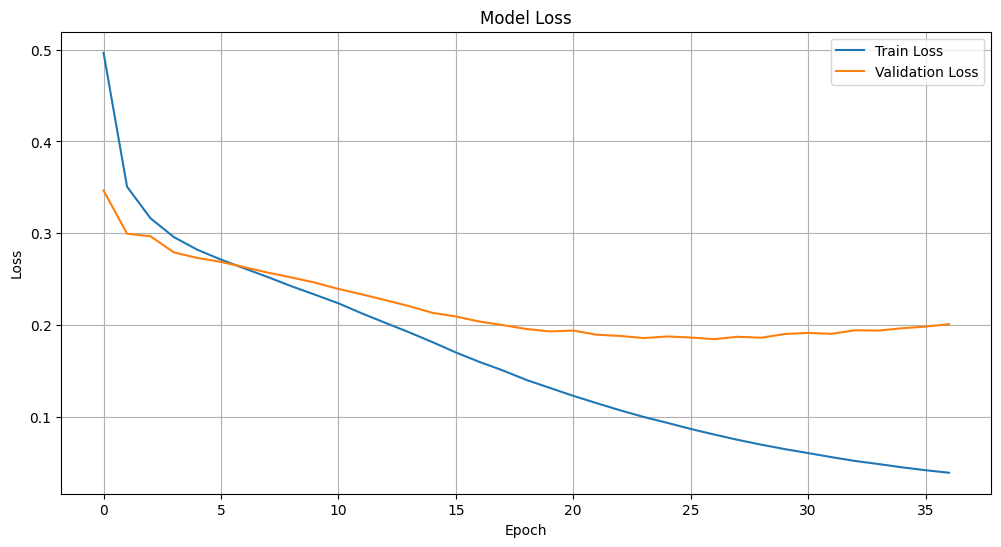

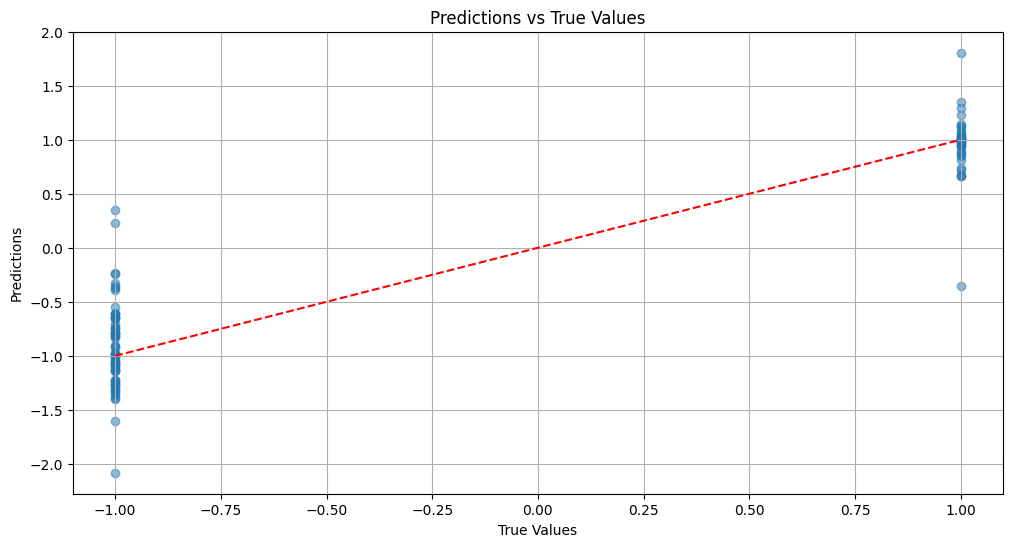

In [85]:
import tensorflow as tf
from tensorflow.keras.optimizers import Adagrad
from tensorflow.keras.callbacks import EarlyStopping, TensorBoard
import numpy as np
import matplotlib.pyplot as plt
from tensorflow.keras import mixed_precision
from sklearn.metrics import log_loss, mean_squared_error

# Enable mixed precision
policy = mixed_precision.Policy('mixed_float16')
mixed_precision.set_global_policy(policy)

# Verify GPU availability
print("Num GPUs Available: ", len(tf.config.list_physical_devices('GPU')))

# Allow memory growth for GPU
gpus = tf.config.list_physical_devices('GPU')
if gpus:
    try:
        for gpu in gpus:
            tf.config.experimental.set_memory_growth(gpu, True)
    except RuntimeError as e:
        print(e)

# Load the pre-trained model with the custom NeuralFM class
pretrained_model_path = 'neural_fm_model.keras'

# Load the model with custom_objects
model = tf.keras.models.load_model(pretrained_model_path, custom_objects={'NeuralFM': NeuralFM})

# Compile the model with the same optimizer and loss function
optimizer = Adagrad(learning_rate=0.05)
model.compile(optimizer=optimizer, loss='binary_crossentropy' if loss_type == 'log_loss' else 'mean_squared_error')

# Function to prepare data
def prepare_data(data):
    X = tf.keras.preprocessing.sequence.pad_sequences(data['X'], padding='post')
    y = np.array(data['Y'])
    return X, y

# Function to create dataset
def create_dataset(X, y, batch_size=128, shuffle=True):
    dataset = tf.data.Dataset.from_tensor_slices((X, y))
    if shuffle:
        dataset = dataset.shuffle(buffer_size=10000)
    dataset = dataset.batch(batch_size).prefetch(buffer_size=tf.data.AUTOTUNE)
    return dataset

# Prepare data for training, validation, and testing
X_train, y_train = prepare_data(loader.Train_data)
X_val, y_val = prepare_data(loader.Validation_data)
X_test, y_test = prepare_data(loader.Test_data)

batch_size = 128
train_dataset = create_dataset(X_train, y_train, batch_size=batch_size)
val_dataset = create_dataset(X_val, y_val, batch_size=batch_size, shuffle=False)
test_dataset = create_dataset(X_test, y_test, batch_size=batch_size, shuffle=False)

# Define early stopping and TensorBoard callback
early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)
tensorboard_callback = TensorBoard(log_dir="./logs", profile_batch=0)

# Continue training the pre-trained model
history_updated = model.fit(
    train_dataset,
    epochs=30,  # You can adjust the number of epochs as needed
    validation_data=val_dataset,
    callbacks=[early_stopping, tensorboard_callback],
    verbose=1
)

# Save the updated model
model.save('neural_fm_model_updated.keras')
print("Updated model saved to neural_fm_model_updated.keras")

# Evaluate the model
y_pred = model.predict(test_dataset)

# Flatten y_pred if it's 2D with the second dimension being 1
if y_pred.ndim == 2 and y_pred.shape[1] == 1:
    y_pred = np.squeeze(y_pred)

# Check shapes
print("Shape of y_test:", y_test.shape)
print("Shape of y_pred:", y_pred.shape)

# Calculate the evaluation metric
if loss_type == 'log_loss':
    score = log_loss(y_test, y_pred)
else:
    score = mean_squared_error(y_test, y_pred)

print(f"Test {loss_type} score: {score}")

# Plot training & validation loss values
plt.figure(figsize=(12, 6))
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Model Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend(loc='upper right')
plt.grid(True)
plt.show()

# Predictions vs True Values for a small subset
sample_size = 100
sample_indices = np.random.choice(len(y_test), size=sample_size, replace=False)
y_test_sample = y_test[sample_indices]
y_pred_sample = y_pred[sample_indices]

plt.figure(figsize=(12, 6))
plt.scatter(y_test_sample, y_pred_sample, alpha=0.5)
plt.plot([min(y_test_sample), max(y_test_sample)], [min(y_test_sample), max(y_test_sample)], color='red', linestyle='--')
plt.title('Predictions vs True Values')
plt.xlabel('True Values')
plt.ylabel('Predictions')
plt.grid(True)
plt.show()


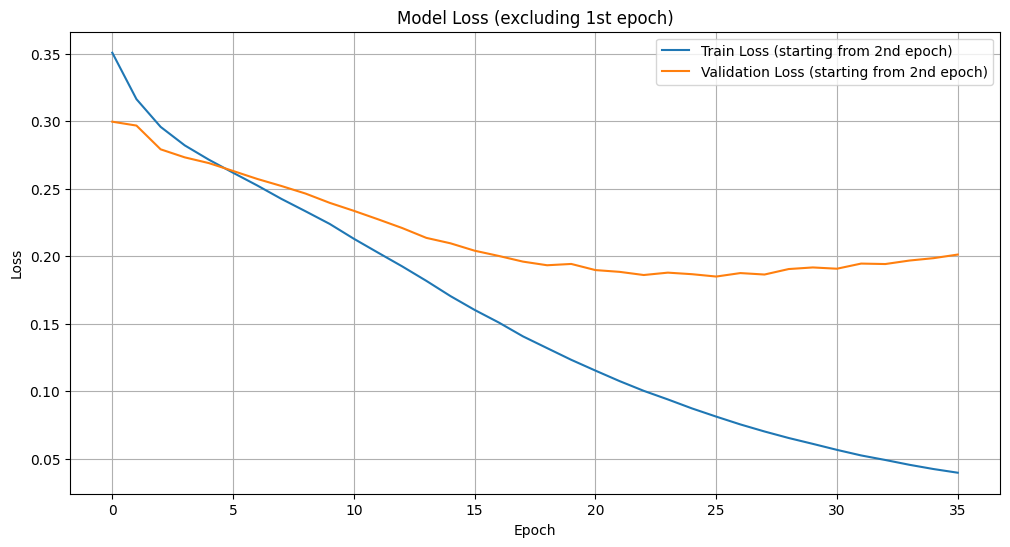

In [86]:
# After training is complete, modify the history to ignore the first epoch
# Get the loss values starting from the second epoch
train_loss = history_updated.history['loss'][1:]
val_loss = history_updated.history['val_loss'][1:]

# Plot the training & validation loss values starting from the second epoch
plt.figure(figsize=(12, 6))
plt.plot(train_loss, label='Train Loss (starting from 2nd epoch)')
plt.plot(val_loss, label='Validation Loss (starting from 2nd epoch)')
plt.title('Model Loss (excluding 1st epoch)')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend(loc='upper right')
plt.grid(True)
plt.show()


In [33]:
import tensorflow as tf
from tensorflow.keras.layers import Embedding, Dense, Dropout

# Register your custom model class
@tf.keras.utils.register_keras_serializable()
class NeuralFM(tf.keras.Model):
    def __init__(self, feature_dim, hidden_factor, layers, keep_prob, loss_type='square_loss', activation='relu'):
        super(NeuralFM, self).__init__()
        self.embedding = Embedding(feature_dim, hidden_factor, mask_zero=False)
        self.hidden_layers = []
        for layer_size in layers:
            self.hidden_layers.append(Dense(layer_size, activation=activation))
        self.output_layer = Dense(1, activation='sigmoid' if loss_type == 'log_loss' else 'linear')
        self.dropout_layers = [Dropout(p) for p in keep_prob]

    def call(self, inputs, training=False):
        x = self.embedding(inputs)
        fm_part = tf.reduce_sum(x, axis=1) ** 2 - tf.reduce_sum(x ** 2, axis=1)
        fm_part = 0.5 * tf.reduce_sum(fm_part, axis=1, keepdims=True)

        x = tf.reduce_sum(x, axis=1)
        for layer, dropout in zip(self.hidden_layers, self.dropout_layers):
            x = layer(x)
            if training:
                x = dropout(x)

        x = tf.concat([x, fm_part], axis=1)
        output = self.output_layer(x)
        return output


# data Visualisation Frappe and ML-tag (movie lens)

In [5]:
import matplotlib.pyplot as plt
import seaborn as sns

def visualize_data_distribution(data, dataset_name='Train'):
    """
    Visualizes data distribution for the given dataset (Train/Validation/Test).

    :param data: Dictionary with 'X' and 'Y' values from the LoadData class
    :param dataset_name: 'Train', 'Validation', or 'Test' to indicate which dataset is being visualized
    """
    # Extract features and labels
    X_data = data['X']
    Y_data = data['Y']

    # Plot label distribution
    plt.figure(figsize=(10, 5))
    sns.histplot(Y_data, bins=2, kde=False)
    plt.title(f'Label Distribution in {dataset_name} Dataset')
    plt.xlabel('Label')
    plt.ylabel('Frequency')
    plt.show()

    # Visualizing the sparsity of the feature matrix
    feature_lengths = [len(x) for x in X_data]

    plt.figure(figsize=(10, 5))
    sns.histplot(feature_lengths, bins=30, kde=False)
    plt.title(f'Feature Vector Length Distribution in {dataset_name} Dataset')
    plt.xlabel('Number of Non-Zero Features per Sample')
    plt.ylabel('Frequency')
    plt.show()


In [6]:
import numpy as np

def visualize_sparsity_matrix(data, dataset_name='Train', num_samples=100, num_features=None):
    """
    Visualizes a sample of the feature matrix sparsity using a heatmap.

    :param data: Dictionary with 'X' and 'Y' values from the LoadData class
    :param dataset_name: 'Train', 'Validation', or 'Test' to indicate which dataset is being visualized
    :param num_samples: Number of samples to visualize
    :param num_features: Number of features (optional, required for heatmap)
    """
    # Limit the data to the first `num_samples` entries
    X_data = data['X'][:num_samples]

    if num_features is None:
        raise ValueError("You must provide the total number of features as `num_features`.")

    # Create a binary matrix indicating where non-zero entries exist
    binary_matrix = np.zeros((num_samples, num_features))

    for i, sample in enumerate(X_data):
        for feature in sample:
            binary_matrix[i, feature] = 1

    # Plot the sparsity pattern
    plt.figure(figsize=(15, 8))
    sns.heatmap(binary_matrix, cmap='Blues', cbar=False)
    plt.title(f'Sparsity Pattern of Feature Matrix in {dataset_name} Dataset (First {num_samples} Samples)')
    plt.xlabel('Features')
    plt.ylabel('Samples')
    plt.show()



In [13]:
# loading data
path = 'data/'  # Update this to your actual data path
dataset = 'frappe'  # Replace with your dataset name
loss_type = 'log_loss'  # Or other loss type as needed

# Create an instance of LoadData
loaded_data = LoadData(path, dataset, loss_type)


In [14]:
# Basic stats about the dataset
def display_data_statistics(data_dict, data_type="Train"):
    print(f"Statistics for {data_type} data:")
    num_samples = len(data_dict['Y'])
    num_features = len(data_dict['X'][0]) if num_samples > 0 else 0
    print(f"Number of samples: {num_samples}")
    print(f"Number of features per sample: {num_features}")
    print(f"First few target values (Y): {data_dict['Y'][:5]}")
    print(f"First few feature sets (X): {data_dict['X'][:5]}")
    print("\n")

display_data_statistics(loaded_data.Train_data, "Train")
display_data_statistics(loaded_data.Validation_data, "Validation")
display_data_statistics(loaded_data.Test_data, "Test")


Statistics for Train data:
Number of samples: 202027
Number of features per sample: 10
First few target values (Y): [1.0, 0.0, 1.0, 0.0, 1.0]
First few feature sets (X): [[243, 1939, 48, 30, 20, 5, 6, 80, 8, 9], [726, 1643, 112, 25, 20, 5, 6, 26, 135, 728], [40, 1386, 38, 12, 4, 5, 6, 7, 8, 9], [249, 3454, 18, 42, 20, 5, 6, 7, 54, 251], [890, 218, 18, 42, 20, 13, 6, 7, 150, 892]]


Statistics for Validation data:
Number of samples: 57722
Number of features per sample: 10
First few target values (Y): [0.0, 0.0, 0.0, 1.0, 0.0]
First few feature sets (X): [[665, 2465, 18, 58, 20, 5, 6, 45, 66, 9], [159, 1684, 24, 25, 20, 5, 6, 26, 161, 210], [351, 1793, 38, 19, 20, 5, 6, 26, 62, 702], [307, 2132, 38, 19, 20, 13, 6, 26, 8, 9], [266, 4264, 112, 58, 20, 5, 6, 45, 66, 9]]


Statistics for Test data:
Number of samples: 28860
Number of features per sample: 10
First few target values (Y): [1.0, 0.0, 0.0, 0.0, 0.0]
First few feature sets (X): [[3817, 3182, 38, 12, 4, 13, 6, 72, 8, 884], [362, 477

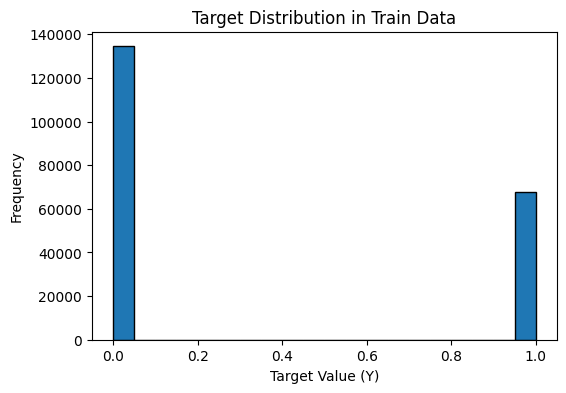

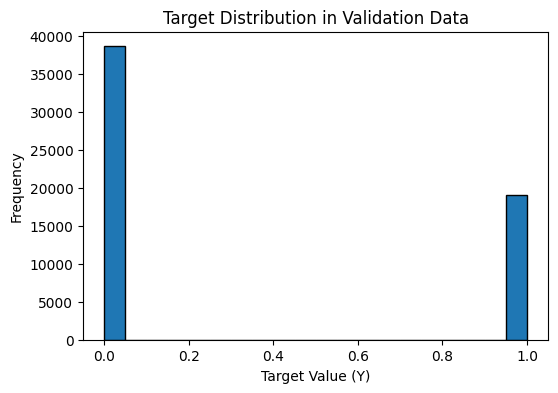

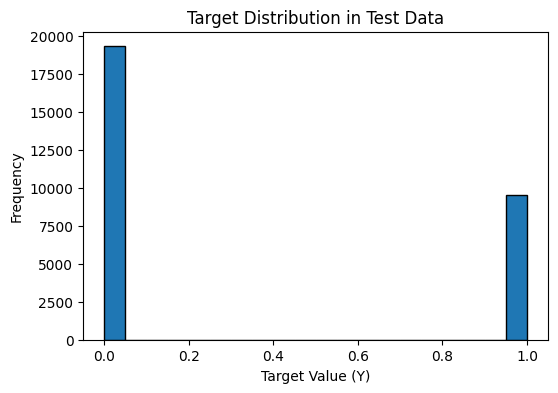

In [16]:
import matplotlib.pyplot as plt

def plot_target_distribution(data_dict, data_type="Train"):
    plt.figure(figsize=(6,4))
    plt.hist(data_dict['Y'], bins=20, edgecolor='black')
    plt.title(f'Target Distribution in {data_type} Data')
    plt.xlabel('Target Value (Y)')
    plt.ylabel('Frequency')
    plt.show()

plot_target_distribution(loaded_data.Train_data, "Train")
plot_target_distribution(loaded_data.Validation_data, "Validation")
plot_target_distribution(loaded_data.Test_data, "Test")


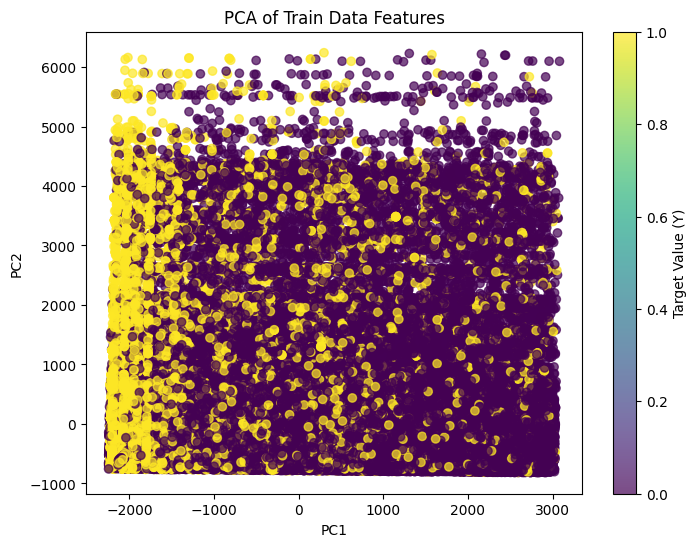

In [19]:
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE

def plot_feature_pca(data_dict, data_type="Train"):
    X_data = np.array(data_dict['X'])
    pca = PCA(n_components=2)
    X_reduced = pca.fit_transform(X_data)

    plt.figure(figsize=(8, 6))
    plt.scatter(X_reduced[:, 0], X_reduced[:, 1], c=data_dict['Y'], cmap='viridis', alpha=0.7)
    plt.colorbar(label='Target Value (Y)')
    plt.title(f'PCA of {data_type} Data Features')
    plt.xlabel('PC1')
    plt.ylabel('PC2')
    plt.show()

plot_feature_pca(loaded_data.Train_data, "Train")


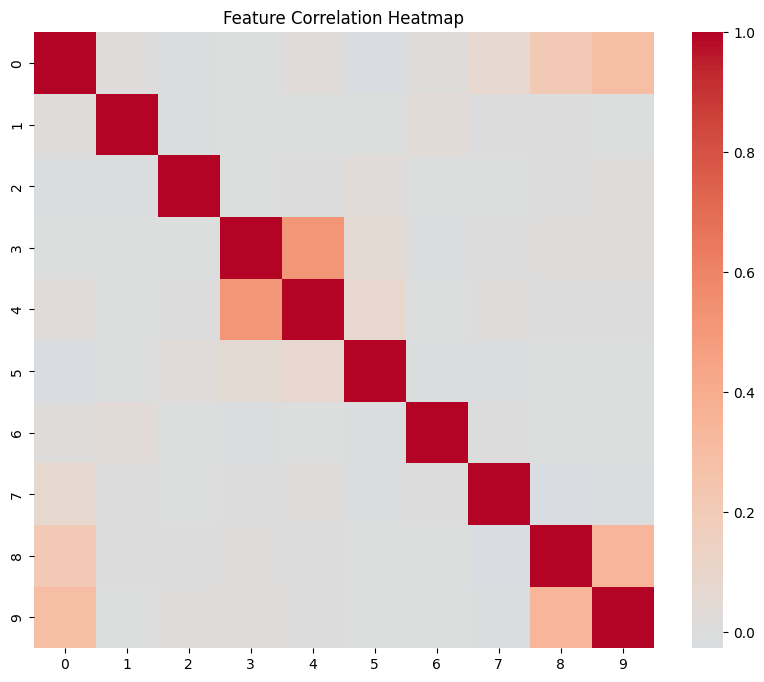

In [23]:
def plot_correlation_heatmap(data_dict):
    X_data = np.array(data_dict['X'])
    corr_matrix = np.corrcoef(X_data.T)
    plt.figure(figsize=(10, 8))
    sns.heatmap(corr_matrix, cmap='coolwarm', center=0)
    plt.title('Feature Correlation Heatmap')
    plt.show()

plot_correlation_heatmap(loaded_data.Train_data)


In [51]:
# Load the trained model
loaded_model = tf.keras.models.load_model('neural_fm_model.keras', custom_objects={'NeuralFM': NeuralFM})

# Verify the model's architecture and summary
loaded_model.summary()


Model: "neural_fm_3"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ embedding_3 (Embedding)              │ (None, 10, 64)              │         344,448 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_6 (Dense)                      │ (None, 64)                  │           4,160 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_7 (Dense)                      │ (None, 1)                   │              66 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_6 (Dropout)                  │ ?                           │     0 (unbuilt) │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_7 (Dropout)                  │ ?                           │     0 (unbuilt) │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 697,354 (2.66 MB)

 Trainable params: 348,674 (1.33 MB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 348,680 (1.33 MB)

# Attempt to implement multi class NFM

In [87]:
from tensorflow.keras.utils import to_categorical

class LoadData(object):
    def __init__(self, path, dataset, num_classes):
        self.path = path + dataset + "/"
        self.trainfile = self.path + dataset + ".train.libfm"
        self.testfile = self.path + dataset + ".test.libfm"
        self.validationfile = self.path + dataset + ".validation.libfm"
        self.features_M = self.map_features()
        self.num_classes = num_classes
        self.Train_data, self.Validation_data, self.Test_data = self.construct_data()

    def map_features(self):
        self.features = {}
        self.read_features(self.trainfile)
        self.read_features(self.testfile)
        self.read_features(self.validationfile)
        return len(self.features)

    def read_features(self, file):
        with open(file) as f:
            line = f.readline()
            i = len(self.features)
            while line:
                items = line.strip().split(' ')
                for item in items[1:]:
                    if item not in self.features:
                        self.features[item] = i
                        i += 1
                line = f.readline()

    def read_data(self, file):
        X_ = []
        Y_ = []
        with open(file) as f:
            line = f.readline()
            while line:
                items = line.strip().split(' ')
                Y_.append(int(items[0]))  # Assuming labels are integers for multiclass
                X_.append([self.features[item] for item in items[1:]])
                line = f.readline()
        # Convert labels to one-hot encoded vectors for multiclass classification
        Y_onehot = to_categorical(Y_, num_classes=self.num_classes)
        return X_, Y_onehot

    def construct_data(self):
        # Prepare data for train, validation, and test sets
        X_train, Y_train = self.read_data(self.trainfile)
        Train_data = self.construct_dataset(X_train, Y_train)

        X_val, Y_val = self.read_data(self.validationfile)
        Validation_data = self.construct_dataset(X_val, Y_val)

        X_test, Y_test = self.read_data(self.testfile)
        Test_data = self.construct_dataset(X_test, Y_test)

        return Train_data, Validation_data, Test_data

    def construct_dataset(self, X_, Y_):
        Data_Dic = {}
        X_lens = [len(line) for line in X_]
        indexs = np.argsort(X_lens)
        Data_Dic['Y'] = [Y_[i] for i in indexs]
        Data_Dic['X'] = [X_[i] for i in indexs]
        return Data_Dic


In [91]:
import tensorflow as tf

class NeuralFM(tf.keras.Model):
    def __init__(self, feature_dim, hidden_factor, layers, keep_prob, num_classes, activation='relu'):
        super(NeuralFM, self).__init__()
        self.feature_dim = feature_dim
        self.hidden_factor = hidden_factor
        self.layers_config = layers
        self.keep_prob = keep_prob
        self.num_classes = num_classes

        # Embedding layer for factorization machine
        self.embedding = tf.keras.layers.Embedding(feature_dim, hidden_factor, mask_zero=False)

        # Hidden layers for the neural network
        self.hidden_layers = [tf.keras.layers.Dense(layer_size, activation=activation) for layer_size in layers]

        # Output layer for multiclass classification with softmax activation
        self.output_layer = tf.keras.layers.Dense(num_classes, activation='softmax')

        # Dropout layers
        self.dropout_layers = [tf.keras.layers.Dropout(p) for p in keep_prob]

    def call(self, inputs, training=False):
        # Embedding lookup
        x = self.embedding(inputs)

        # FM part: Interaction terms between features
        fm_part = tf.reduce_sum(x, axis=1) ** 2 - tf.reduce_sum(x ** 2, axis=1)
        fm_part = 0.5 * tf.reduce_sum(fm_part, axis=1, keepdims=True)

        # NN part: Apply hidden layers
        x = tf.reduce_sum(x, axis=1)
        for layer, dropout in zip(self.hidden_layers, self.dropout_layers):
            x = layer(x)
            if training:
                x = dropout(x)

        # Concatenate FM and NN part
        x = tf.concat([x, fm_part], axis=1)

        # Output layer (softmax for multiclass classification)
        output = self.output_layer(x)
        return output


In [92]:
# Initialize data loader
path = 'data/'
dataset = 'frappe'
num_classes = 3  # Example number of classes

# Load data
loader = LoadData(path, dataset, num_classes)
feature_dim = loader.features_M
hidden_factor = 64
layers = [64]
keep_prob = [0.8, 0.5]

# Create NeuralFM model
model = NeuralFM(
    feature_dim=feature_dim,
    hidden_factor=hidden_factor,
    layers=layers,
    keep_prob=keep_prob,
    num_classes=num_classes,
    activation='relu'
)

# Compile model for multiclass classification
optimizer = Adagrad(learning_rate=0.05)
model.compile(
    optimizer=optimizer,
    loss='categorical_crossentropy',
    metrics=['accuracy']
)


In [93]:
def prepare_data(data):
    X = tf.keras.preprocessing.sequence.pad_sequences(data['X'], padding='post')
    y = np.array(data['Y'])
    return X, y

def create_dataset(X, y, batch_size=128, shuffle=True):
    dataset = tf.data.Dataset.from_tensor_slices((X, y))
    if shuffle:
        dataset = dataset.shuffle(buffer_size=10000)
    dataset = dataset.batch(batch_size).prefetch(buffer_size=tf.data.AUTOTUNE)
    return dataset

# Prepare training, validation, and test data
X_train, y_train = prepare_data(loader.Train_data)
X_val, y_val = prepare_data(loader.Validation_data)
X_test, y_test = prepare_data(loader.Test_data)

batch_size = 128
train_dataset = create_dataset(X_train, y_train, batch_size=batch_size)
val_dataset = create_dataset(X_val, y_val, batch_size=batch_size, shuffle=False)
test_dataset = create_dataset(X_test, y_test, batch_size=batch_size, shuffle=False)

# Define callbacks
early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)
tensorboard_callback = TensorBoard(log_dir="./logs", profile_batch=0)

# Train model
history_multiclass = model.fit(
    train_dataset,
    epochs=200,
    validation_data=val_dataset,
    callbacks=[early_stopping, tensorboard_callback],
    verbose=1
)

# Save model
model.save('neural_fm_model_multiclass.keras')


Epoch 1/200


/usr/local/lib/python3.10/dist-packages/keras/src/layers/layer.py:372: UserWarning: `build()` was called on layer 'neural_fm_28', however the layer does not have a `build()` method implemented and it looks like it has unbuilt state. This will cause the layer to be marked as built, despite not being actually built, which may cause failures down the line. Make sure to implement a proper `build()` method.
  warnings.warn(


1579/1579 ━━━━━━━━━━━━━━━━━━━━ 21s 12ms/step - accuracy: 0.7172 - loss: 0.5948 - val_accuracy: 0.8718 - val_loss: 0.3440
Epoch 2/200
1579/1579 ━━━━━━━━━━━━━━━━━━━━ 19s 11ms/step - accuracy: 0.8532 - loss: 0.3732 - val_accuracy: 0.8591 - val_loss: 0.3401
Epoch 3/200
1579/1579 ━━━━━━━━━━━━━━━━━━━━ 22s 12ms/step - accuracy: 0.8701 - loss: 0.3330 - val_accuracy: 0.8901 - val_loss: 0.3031
Epoch 4/200
1579/1579 ━━━━━━━━━━━━━━━━━━━━ 18s 11ms/step - accuracy: 0.8787 - loss: 0.3077 - val_accuracy: 0.8887 - val_loss: 0.2800
Epoch 5/200
1579/1579 ━━━━━━━━━━━━━━━━━━━━ 18s 11ms/step - accuracy: 0.8837 - loss: 0.2925 - val_accuracy: 0.8918 - val_loss: 0.2736
Epoch 6/200
1579/1579 ━━━━━━━━━━━━━━━━━━━━ 21s 12ms/step - accuracy: 0.8884 - loss: 0.2807 - val_accuracy: 0.8923 - val_loss: 0.2716
Epoch 7/200
1579/1579 ━━━━━━━━━━━━━━━━━━━━ 21s 12ms/step - accuracy: 0.8918 - loss: 0.2692 - val_accuracy: 0.8944 - val_loss: 0.2718
Epoch 8/200
1579/1579 ━━━━━━━━━━━━━━━━━━━━ 21s 12ms/step - accuracy: 0.8959 - los

In [99]:
from tensorflow.keras.models import load_model


model_multiclass = load_model('neural_fm_model_multiclass.keras', custom_objects={'NeuralFM': NeuralFM})
# Evaluate model on test data
y_pred = model.predict(test_dataset)

# Since y_test is one-hot encoded, convert predictions and actuals back to class labels
y_pred_classes = np.argmax(y_pred, axis=1)
y_test_classes = np.argmax(y_test, axis=1)

# Evaluate accuracy
accuracy = np.mean(y_pred_classes == y_test_classes)
print(f"Test accuracy: {accuracy}")

# Additional evaluation metrics (optional)
from sklearn.metrics import classification_report
print(classification_report(y_test_classes, y_pred_classes))


TypeError: <class '__main__.NeuralFM'> could not be deserialized properly. Please ensure that components that are Python object instances (layers, models, etc.) returned by `get_config()` are explicitly deserialized in the model's `from_config()` method.

config={'module': None, 'class_name': 'NeuralFM', 'config': {'trainable': True, 'dtype': {'module': 'keras', 'class_name': 'DTypePolicy', 'config': {'name': 'mixed_float16'}, 'registered_name': None}}, 'registered_name': 'NeuralFM', 'build_config': {'input_shape': [None, 10]}, 'compile_config': {'optimizer': {'module': 'keras.optimizers', 'class_name': 'Adagrad', 'config': {'name': 'adagrad', 'learning_rate': 0.05000000074505806, 'weight_decay': None, 'clipnorm': None, 'global_clipnorm': None, 'clipvalue': None, 'use_ema': False, 'ema_momentum': 0.99, 'ema_overwrite_frequency': None, 'loss_scale_factor': None, 'gradient_accumulation_steps': None, 'initial_accumulator_value': 0.1, 'epsilon': 1e-07}, 'registered_name': None}, 'loss': 'categorical_crossentropy', 'loss_weights': None, 'metrics': ['accuracy'], 'weighted_metrics': None, 'run_eagerly': False, 'steps_per_execution': 1, 'jit_compile': False}}.

Exception encountered: NeuralFM.__init__() got an unexpected keyword argument 'trainable'

In [100]:
import matplotlib.pyplot as plt


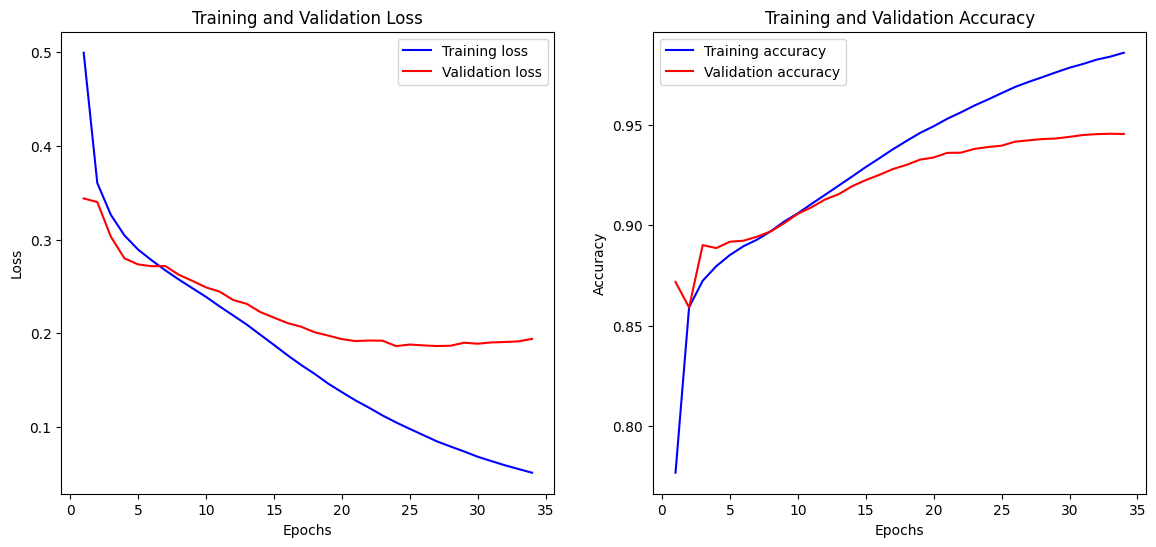

In [101]:
# Extract the loss and accuracy from the history object
train_loss = history_multiclass.history['loss']
val_loss = history_multiclass.history['val_loss']
train_accuracy = history_multiclass.history['accuracy']
val_accuracy = history_multiclass.history['val_accuracy']

# Number of epochs
epochs = range(1, len(train_loss) + 1)

# Plot the loss over epochs
plt.figure(figsize=(14, 6))

plt.subplot(1, 2, 1)
plt.plot(epochs, train_loss, 'b', label='Training loss')
plt.plot(epochs, val_loss, 'r', label='Validation loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

# Plot the accuracy over epochs
plt.subplot(1, 2, 2)
plt.plot(epochs, train_accuracy, 'b', label='Training accuracy')
plt.plot(epochs, val_accuracy, 'r', label='Validation accuracy')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

plt.show()


# model comparisons


# combined code for NFM class

In [103]:
import tensorflow as tf
from tensorflow.keras.layers import Embedding, Dense, Dropout

@tf.keras.utils.register_keras_serializable()
class NeuralFM(tf.keras.Model):
    def __init__(self, feature_dim, hidden_factor, layers, keep_prob, loss_type='square_loss', activation='relu'):
        super(NeuralFM, self).__init__()
        self.feature_dim = feature_dim
        self.hidden_factor = hidden_factor
        self.layers_config = layers
        self.keep_prob = keep_prob
        self.loss_type = loss_type
        self.activation = activation

        # Define layers
        self.embedding = Embedding(feature_dim, hidden_factor, mask_zero=False)
        self.hidden_layers = [Dense(layer_size, activation=activation) for layer_size in layers]
        self.output_layer = Dense(1, activation='sigmoid' if loss_type == 'log_loss' else 'linear')
        self.dropout_layers = [Dropout(p) for p in keep_prob]

    def call(self, inputs, training=False):
        x = self.embedding(inputs)
        fm_part = tf.reduce_sum(x, axis=1) ** 2 - tf.reduce_sum(x ** 2, axis=1)
        fm_part = 0.5 * tf.reduce_sum(fm_part, axis=1, keepdims=True)

        x = tf.reduce_sum(x, axis=1)
        for layer, dropout in zip(self.hidden_layers, self.dropout_layers):
            x = layer(x)
            if training:
                x = dropout(x)

        x = tf.concat([x, fm_part], axis=1)
        output = self.output_layer(x)
        return output

    def get_config(self):
        return {
            'feature_dim': self.feature_dim,
            'hidden_factor': self.hidden_factor,
            'layers': self.layers_config,
            'keep_prob': self.keep_prob,
            'loss_type': self.loss_type,
            'activation': self.activation,
        }

    @classmethod
    def from_config(cls, config):
        return cls(**config)


In [105]:
import tensorflow as tf
from tensorflow.keras.layers import Embedding, Dense, Dropout

@tf.keras.utils.register_keras_serializable()
class NeuralFM(tf.keras.Model):
    def __init__(self, feature_dim, hidden_factor, layers, keep_prob, num_classes, activation='relu'):
        super(NeuralFM, self).__init__()
        self.feature_dim = feature_dim
        self.hidden_factor = hidden_factor
        self.layers_config = layers
        self.keep_prob = keep_prob
        self.num_classes = num_classes
        self.activation = activation

        # Define layers
        self.embedding = Embedding(feature_dim, hidden_factor, mask_zero=False)
        self.hidden_layers = [Dense(layer_size, activation=activation) for layer_size in layers]
        self.dropout_layers = [Dropout(p) for p in keep_prob]
        self.output_layer = Dense(num_classes, activation='softmax')  # Multi-class output layer

    def call(self, inputs, training=False):
        x = self.embedding(inputs)
        fm_part = tf.reduce_sum(x, axis=1) ** 2 - tf.reduce_sum(x ** 2, axis=1)
        fm_part = 0.5 * tf.reduce_sum(fm_part, axis=1, keepdims=True)

        x = tf.reduce_sum(x, axis=1)
        for layer, dropout in zip(self.hidden_layers, self.dropout_layers):
            x = layer(x)
            if training:
                x = dropout(x)

        x = tf.concat([x, fm_part], axis=1)
        output = self.output_layer(x)
        return output

    def get_config(self):
        return {
            'feature_dim': self.feature_dim,
            'hidden_factor': self.hidden_factor,
            'layers': self.layers_config,
            'keep_prob': self.keep_prob,
            'num_classes': self.num_classes,
            'activation': self.activation,
        }

    @classmethod
    def from_config(cls, config):
        return cls(**config)


In [111]:
from tensorflow.keras.models import load_model

# # Load models with custom objects
# model_binary = load_model('neural_fm_model.keras', custom_objects={'NeuralFM': NeuralFM})
# model_updated = load_model('neural_fm_model_updated.keras', custom_objects={'NeuralFM': NeuralFM})
model_multiclass = load_model('neural_fm_model_multiclass.keras', custom_objects={'NeuralFM': NeuralFM})


TypeError: <class '__main__.NeuralFM'> could not be deserialized properly. Please ensure that components that are Python object instances (layers, models, etc.) returned by `get_config()` are explicitly deserialized in the model's `from_config()` method.

config={'module': None, 'class_name': 'NeuralFM', 'config': {'trainable': True, 'dtype': {'module': 'keras', 'class_name': 'DTypePolicy', 'config': {'name': 'mixed_float16'}, 'registered_name': None}}, 'registered_name': 'NeuralFM', 'build_config': {'input_shape': [None, 10]}, 'compile_config': {'optimizer': {'module': 'keras.optimizers', 'class_name': 'Adagrad', 'config': {'name': 'adagrad', 'learning_rate': 0.05000000074505806, 'weight_decay': None, 'clipnorm': None, 'global_clipnorm': None, 'clipvalue': None, 'use_ema': False, 'ema_momentum': 0.99, 'ema_overwrite_frequency': None, 'loss_scale_factor': None, 'gradient_accumulation_steps': None, 'initial_accumulator_value': 0.1, 'epsilon': 1e-07}, 'registered_name': None}, 'loss': 'categorical_crossentropy', 'loss_weights': None, 'metrics': ['accuracy'], 'weighted_metrics': None, 'run_eagerly': False, 'steps_per_execution': 1, 'jit_compile': False}}.

Exception encountered: NeuralFM.__init__() got an unexpected keyword argument 'trainable'

In [112]:
from tensorflow.keras.models import load_model

# # Load models with custom objects
model_binary = load_model('neural_fm_model.keras', custom_objects={'NeuralFM': NeuralFM})
# model_updated = load_model('neural_fm_model_updated.keras', custom_objects={'NeuralFM': NeuralFM})

In [113]:
model_updated = load_model('neural_fm_model_updated.keras', custom_objects={'NeuralFM': NeuralFM})

In [114]:
# Prepare test data
X_test, y_test = prepare_data(loader.Test_data)
test_dataset = create_dataset(X_test, y_test, batch_size=128, shuffle=False)


In [115]:
# Evaluate binary classification model
y_pred_binary = model_binary.predict(test_dataset)
y_test_binary = y_test  # Assuming y_test is already binary

# Evaluate multiclass classification model
y_pred_multiclass = model_multiclass.predict(test_dataset)
y_test_multiclass = np.argmax(y_test, axis=1)  # Convert one-hot encoded to class labels

# Evaluate updated model
y_pred_updated = model_updated.predict(test_dataset)


226/226 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step
226/226 ━━━━━━━━━━━━━━━━━━━━ 2s 7ms/step
226/226 ━━━━━━━━━━━━━━━━━━━━ 2s 7ms/step


In [119]:
from sklearn.metrics import accuracy_score, classification_report

# Convert predictions to class labels
y_pred_binary_labels = np.round(y_pred_binary).astype(int)
y_pred_multiclass_labels = np.argmax(y_pred_multiclass, axis=1)
y_pred_updated_labels = np.argmax(y_pred_updated, axis=1)  # Assuming the updated model is multiclass

# Accuracy and classification report
# accuracy_binary = accuracy_score(y_test_binary, y_pred_binary_labels)
accuracy_multiclass = accuracy_score(y_test_multiclass, y_pred_multiclass_labels)
accuracy_updated = accuracy_score(y_test_multiclass, y_pred_updated_labels)

# report_binary = classification_report(y_test_binary, y_pred_binary_labels)
report_multiclass = classification_report(y_test_multiclass, y_pred_multiclass_labels)
report_updated = classification_report(y_test_multiclass, y_pred_updated_labels)

# print(f"Binary Model Accuracy: {accuracy_binary}")
print(f"Multiclass Model Accuracy: {accuracy_multiclass}")
print(f"Updated Model Accuracy: {accuracy_updated}")

# print("\nBinary Classification Report:")
# print(report_binary)

print("\nMulticlass Classification Report:")
print(report_multiclass)

print("\nUpdated Classification Report:")
print(report_updated)


Multiclass Model Accuracy: 0.9418225918225919
Updated Model Accuracy: 0.0

Multiclass Classification Report:
              precision    recall  f1-score   support

           1       0.92      0.90      0.91      9536
           2       0.95      0.96      0.96     19324

    accuracy                           0.94     28860
   macro avg       0.94      0.93      0.93     28860
weighted avg       0.94      0.94      0.94     28860


Updated Classification Report:
              precision    recall  f1-score   support

           0       0.00      0.00      0.00       0.0
           1       0.00      0.00      0.00    9536.0
           2       0.00      0.00      0.00   19324.0

    accuracy                           0.00   28860.0
   macro avg       0.00      0.00      0.00   28860.0
weighted avg       0.00      0.00      0.00   28860.0



/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.

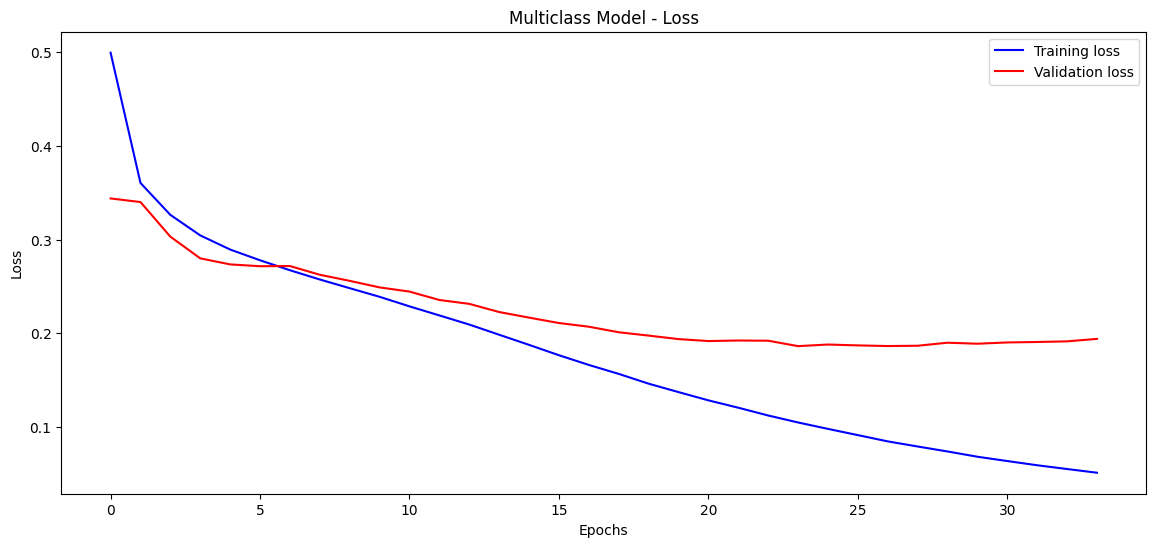

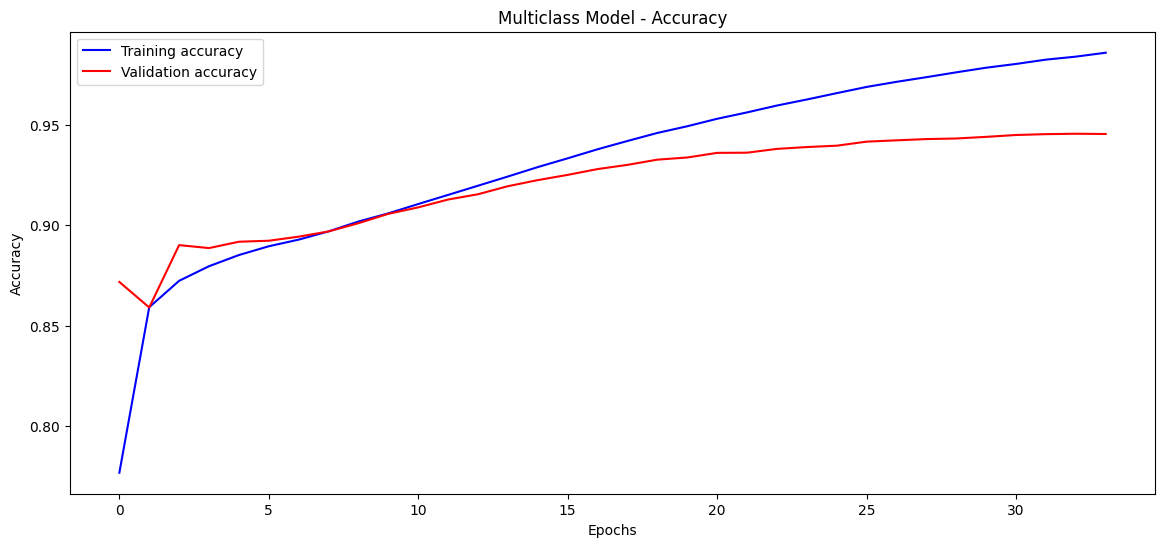

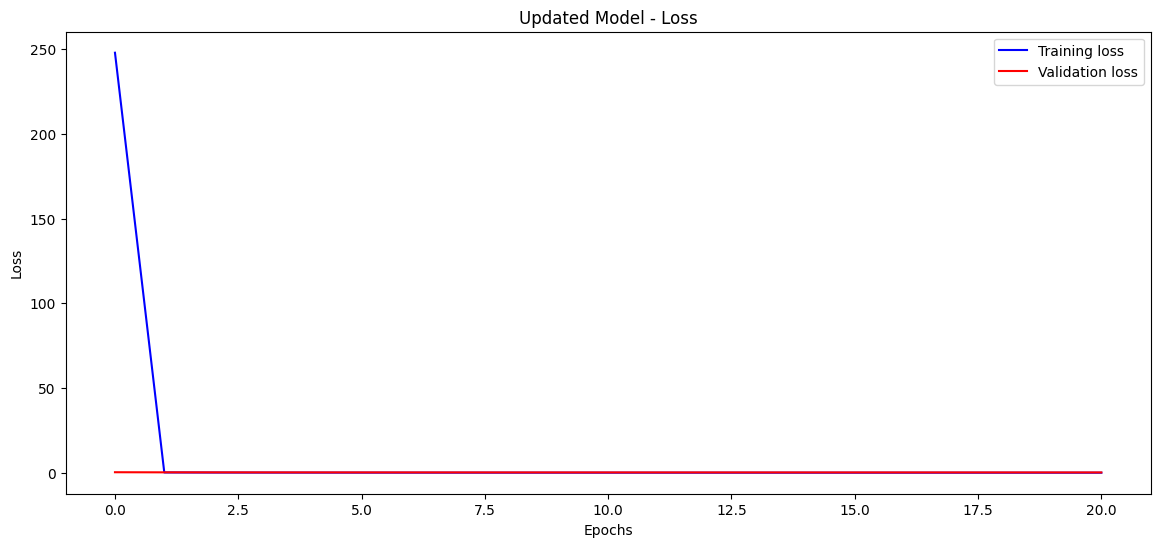

KeyError: 'accuracy'

<Figure size 1400x600 with 0 Axes>

In [121]:
def plot_history(history, title):
    plt.figure(figsize=(14, 6))
    plt.plot(history.history['loss'], 'b', label='Training loss')
    plt.plot(history.history['val_loss'], 'r', label='Validation loss')
    plt.title(f'{title} - Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()
    plt.show()

    plt.figure(figsize=(14, 6))
    # plt.plot(history.history['accuracy'], 'b', label='Training accuracy')
    plt.plot(history.history['val_accuracy'], 'r', label='Validation accuracy')
    plt.title(f'{title} - Accuracy')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.legend()
    plt.show()

# Assuming you have the history objects
# Plot histories for each model
# plot_history(history_binary, 'Binary Model')
plot_history(history_multiclass, 'Multiclass Model')
plot_history(history_updated, 'Updated Model')
